In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import BaggingClassifier

In [4]:
#Here I want to test some regressors

import numpy as np
import h5py
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

In [5]:
#Now it turns out my sample is very biased
#about 1% of the dm particles have associated stellar mass
#
#Apparently you can pass a bias to the network and it will
#work with that
#
#First load the data

f_halo = h5py.File('../m12i_res_7100_cdm/halo_600.hdf5')

pos_halo = f_halo['position'][:]
mass_halo = f_halo['mass'][:]
radius_halo = f_halo['radius'][:]
vel_halo = f_halo['velocity'][:]

#identify the host                                                                                                   \
                                                                                                                      
host_id = np.argmax(mass_halo)
host_mass = mass_halo[host_id]
host_pos = pos_halo[host_id]
host_vel = vel_halo[host_id]

f = h5py.File('DM_data_w_stars_training.hdf5')

coords = f['PartType1']['Coordinates'][:]
vel = f['PartType1']['Velocities'][:]
mass_ratio = f['PartType1']['Mass_Ratio'][:]

In [6]:
diff_coord = coords-host_pos
diff_vel = vel - host_vel

dist  = np.linalg.norm(diff_coord,axis=1)
gal_select = (dist<100.0)

diff_coord_gal = diff_coord[gal_select]
diff_vel_gal = diff_vel[gal_select]
mass_ratio_gal = mass_ratio[gal_select]

phase_space_coords =  np.concatenate((diff_coord_gal,diff_vel_gal),axis=1)

print len(dist)
print len(mass_ratio_gal)

print (np.sum(mass_ratio_gal>0.0))

70514272
15489004
342360


In [30]:
X_train, X_test, y_train, y_test = train_test_split(phase_space_coords,mass_ratio_gal,
                                                    test_size=0.99,random_state=102)

In [46]:
print len(y_train), len(y_test), len(mass_ratio_gal)


y_all = np.array((mass_ratio_gal!=0),dtype=int)

neg, pos = np.bincount(y_all)

print neg, pos

initial_bias = np.log([float(pos)/float(neg)])

print initial_bias

154890 15334114 15489004
15146644 342360
[-3.78967145]


In [31]:
y_train_classifier  = np.array((y_train!=0),dtype=int)

151485 3405
[-3.79524167]


In [56]:
def build_model(output_bias=None):
    
    METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
    
    output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([layers.Flatten(input_shape=(6,)),
                              layers.Dense(64, activation='relu'),
                              layers.Dense(64, activation='relu'),
                              layers.Dropout(0.5),
                              layers.Dense(1, activation='sigmoid',bias_initializer=output_bias)
                             ])
    
    optimizer = keras.optimizers.Adam(lr=1e-3)

    #Can use BinaryCrossentropy because I have only two labels                                                        
    #loss  = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss  = tf.keras.losses.BinaryCrossentropy()
    
    model.compile(loss=loss,optimizer=optimizer,metrics=METRICS)
    
    return model

print 'I guess we build this thing'

model = build_model(output_bias=initial_bias)

I guess we build this thing


In [58]:
EPOCHS = 1000
BATCH_SIZE=2048
history = model.fit(X_train, y_train_classifier, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

In [59]:
y_test_classifier  = np.array((y_test!=0),dtype=int)

model.evaluate(X_test,y_test_classifier,batch_size=BATCH_SIZE,verbose=2)

15334114/15334114 - 17s - loss: 0.0384 - tp: 150140.0000 - fp: 32183.0000 - tn: 14962976.0000 - fn: 188815.0000 - accuracy: 0.9856 - precision: 0.8235 - recall: 0.4429 - auc: 0.9787


[0.03837270337137236,
 150140.0,
 32183.0,
 14962976.0,
 188815.0,
 0.98558784,
 0.8234836,
 0.44294965,
 0.9787303]

In [60]:
y_predict = model.predict(X_test)

In [69]:
len(y_predict)
np.max(y_predict)

np.sum(y_predict>0.001)

2562926

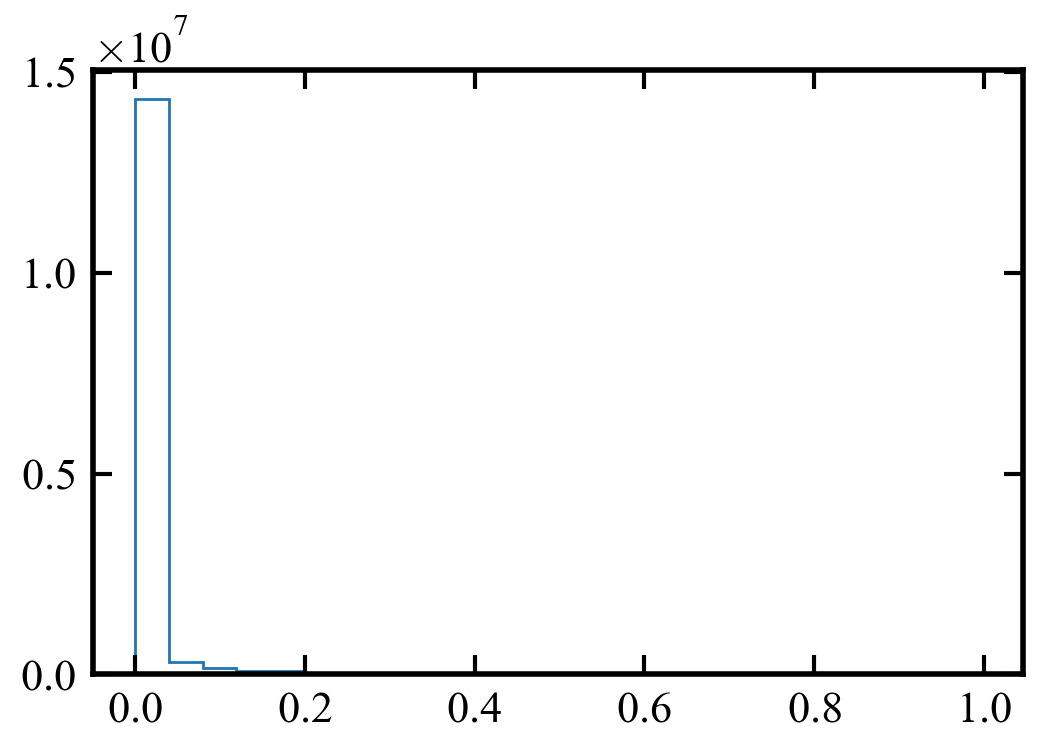

In [62]:
plt.hist(y_predict,bins=25,histtype='step')
plt.show()